In [87]:
# required modules

from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np 
import pandas as pd
import xgboost as xgb
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [2]:
#loading data

player=pd.read_csv("dataset/Player.csv",encoding="ISO-8859-1")
match=pd.read_csv("dataset/Match.csv",encoding="ISO-8859-1")
team=pd.read_csv("dataset/Team.csv",encoding="ISO-8859-1")
ball_by_ball=pd.read_csv("dataset/Ball_By_Ball.csv",encoding="ISO-8859-1")
palayer_match=pd.read_csv("dataset/Player_match.csv",encoding="ISO-8859-1")

In [3]:
# replacing null values in batting postion,Player_Out

ball_by_ball.MatcH_id.value_counts()
ball_by_ball.Striker_Batting_Position.fillna(4,inplace=True)
ball_by_ball.Player_Out.fillna(value=0, inplace=True)

In [4]:
ball_by_ball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150451 entries, 0 to 150450
Data columns (total 48 columns):
MatcH_id                    150451 non-null int64
Over_id                     150451 non-null int64
Ball_id                     150451 non-null int64
Innings_No                  150451 non-null int64
Team_Batting                150451 non-null object
Team_Bowling                150451 non-null object
Striker_Batting_Position    150451 non-null float64
Extra_Type                  150451 non-null object
Runs_Scored                 150451 non-null int64
Extra_runs                  150451 non-null int64
Wides                       150451 non-null int64
Legbyes                     150451 non-null int64
Byes                        150451 non-null int64
Noballs                     150451 non-null int64
Penalty                     150451 non-null int64
Bowler_Extras               150451 non-null int64
Out_type                    150451 non-null object
Caught                      15045

In [7]:
#basic data extraction from ball_by_ball data

features=["MatcH_id","Over_id","Innings_No","Runs_Scored","Extra_runs"]
data=ball_by_ball[features]

In [9]:
#creating  new id

data['id'] = data['MatcH_id'].apply(str)+","+data['Innings_No'].apply(str)+","+data['Over_id'].apply(str)

def index(x):
    tok=x.split(",")
    if(len(tok[2])==1):
        tok[2]='0'+tok[2]
    return ",".join(tok)
data["id"]=data.id.apply(index)
data = pd.DataFrame(data[['id','Runs_Scored',"Extra_runs"]].groupby('id').sum())
data.head(10)

/home/bukka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/bukka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Runs_Scored,Extra_runs
id,,
"1082591,1,01",4,3
"1082591,1,02",15,1
"1082591,1,03",6,0
"1082591,1,04",4,0
"1082591,1,05",9,0
"1082591,1,06",17,0
"1082591,1,07",5,0
"1082591,1,08",11,0
"1082591,1,09",9,0


In [10]:
# function to find bowler id

def bowler(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'Bowler']
    return(a[a.index[0]])

data['id'] = data.index
data["Bowler"]=data.id.apply(lambda x:bowler(x))

In [13]:
# function to find whether a paticular bowler is spiner or pacer 

spin_off=["Right-arm offbreak"," Right-arm offbreak","Slow left-arm orthodox"]
spin_leg=["Legbreak googly","Legbreak"," Legbreak", "Slow left-arm chinaman"]

def spinners(x):
    a=player.loc[player.Player_Id==x,'Bowling_skill']
    if(a[a.index[0]] in spin_off):
        return 1
    elif(a[a.index[0]] in spin_leg):
        return 2
    else :
        return 0
data["BowlerType"]=data.Bowler.apply(spinners)    

In [88]:
# function to find batsman id

def striker(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'Striker']
    return(a[a.index[0]])

data["Striker"]=data.id.apply(lambda x:striker(x))


In [19]:
# function to find batting style of batsman

def Batting_style(x):
    x=player.loc[(player.Player_Id)==x,'Batting_hand']
    return x[x.index[0]].strip()

data["batting_hand"]=data.Striker.apply(Batting_style)

# encoding batting syle
le=LabelEncoder()
data["batting_hand"]=le.fit_transform(data["batting_hand"])

In [20]:
# finding the position of batsman in order

def Striker_Batting_Position(x):
    ok=x.split(",")
    a=ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'Striker_Batting_Position']
    return(a[a.index[0]])

data["strike_position"]=data.id.apply(lambda x:Striker_Batting_Position(x))

In [25]:
# no of players were out till that over

def PlayerOut(x):
    ok=x.split(",")
    mid= int(ok[0])
    iid=int(ok[1])
    oid=int(ok[2])
    if(oid==1):
        return 0
    else:
        a=ball_by_ball.loc[(ball_by_ball.MatcH_id==mid)&(ball_by_ball.Innings_No==iid)&(ball_by_ball.Over_id==oid-1),'Player_Out']
        count=0
        for i in a:
            if(i!=0):
                count+=1
        return(count)
    
data["playerout"]=data.id.apply(lambda x:PlayerOut(x))
    

In [26]:
# no of players were out in present over


def PlayerOut1(x):
    ok=x.split(",")
    mid= int(ok[0])
    iid=int(ok[1])
    oid=int(ok[2])
    a=ball_by_ball.loc[(ball_by_ball.MatcH_id==mid)&(ball_by_ball.Innings_No==iid)&(ball_by_ball.Over_id==oid),'Player_Out']
    count=0
    for i in a:
        if(i!=0):
            count+=1
    return(count)

data["wickets"]=data.id.apply(lambda x:PlayerOut1(x))

In [28]:
# Finding Match Date Sk

def MatchDateSK(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'MatchDateSK']
    return(max(a))

data['matchdatesk']=data.id.apply(lambda x:MatchDateSK(x))

In [30]:
# Finding Batting Team Sk

def BattingTeamSK(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'BattingTeam_SK']
    return(max(a))

data['battingteamsk']=data.id.apply(lambda x:BattingTeamSK(x))

In [31]:
# Finding Bowling Team Sk

def BowlingTeamSK(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'BowlingTeam_SK']
    return(max(a))

data['bowlingteamsk']=data.id.apply(lambda x:BowlingTeamSK(x))

In [34]:
# Finding Date Of the mataches

def MatchDate(x):
    ok=x.split(",")
    a= ball_by_ball.loc[(ball_by_ball.MatcH_id==int(ok[0]))&(ball_by_ball.Innings_No==int(ok[1]))&(ball_by_ball.Over_id==int(ok[2])),'Match_Date']
    return(max(a))

data["matchdate"]=data.id.apply(lambda x:MatchDate(x))

In [37]:
# finding totalruns for an over and classifing whether it is a high runs over or not

data['total_runs']=data['Runs_Scored']+data['Extra_runs']
data['high_runs']=data['total_runs']>=12

In [38]:
# calculating the skill of batsman

bat_skill = data.groupby(['Striker', 'high_runs'])['Striker'].count().unstack('high_runs').fillna(0)
bat_skill["sum"]=bat_skill[True]+bat_skill[False]
bat_skill['Striker'] = bat_skill.index
dicta=bat_skill.to_dict()
def bat_skill(x):
    return dicta[True][x]
data['bat_skill']=data['Striker'].apply(bat_skill)
dicta

{False: {1: 193.0,
  2: 299.0,
  3: 24.0,
  4: 141.0,
  5: 15.0,
  6: 282.0,
  7: 14.0,
  8: 502.0,
  9: 359.0,
  10: 92.0,
  11: 36.0,
  12: 4.0,
  13: 3.0,
  14: 37.0,
  15: 17.0,
  16: 3.0,
  17: 316.0,
  18: 94.0,
  19: 249.0,
  20: 303.0,
  21: 419.0,
  22: 18.0,
  23: 142.0,
  24: 35.0,
  25: 34.0,
  26: 206.0,
  27: 222.0,
  28: 29.0,
  29: 128.0,
  30: 2.0,
  31: 233.0,
  32: 224.0,
  33: 35.0,
  34: 4.0,
  35: 191.0,
  36: 9.0,
  37: 2.0,
  38: 29.0,
  39: 5.0,
  40: 491.0,
  41: 206.0,
  42: 438.0,
  43: 6.0,
  44: 68.0,
  45: 6.0,
  46: 446.0,
  47: 13.0,
  48: 71.0,
  49: 17.0,
  50: 50.0,
  51: 7.0,
  52: 106.0,
  53: 221.0,
  54: 115.0,
  55: 34.0,
  56: 97.0,
  57: 448.0,
  58: 21.0,
  59: 8.0,
  60: 9.0,
  61: 10.0,
  62: 135.0,
  63: 53.0,
  64: 197.0,
  65: 39.0,
  66: 10.0,
  67: 56.0,
  68: 13.0,
  69: 9.0,
  70: 6.0,
  71: 107.0,
  72: 3.0,
  73: 5.0,
  74: 103.0,
  75: 1.0,
  76: 11.0,
  77: 1.0,
  79: 129.0,
  80: 10.0,
  81: 26.0,
  82: 17.0,
  83: 15.0,
  84: 4

In [39]:
# calculating the experience of player
def experience(x):
    return dicta["sum"][x]
data['bat_Experience']=data['Striker'].apply(experience)

In [41]:
# finding cumulative high score overs
data["cumulative_overs"]=0

def cumulative(x):
    a=x.split(",")
    mth=int(a[0])
    inid=int(a[1])
    ovid=int(a[2])
    if(ovid==1):
        return 0
    else:
        if(len(str(ovid-1))==1):
            f=str(mth)+","+str(inid)+","+"0"+str(ovid-1)
        else:
            f=str(mth)+","+str(inid)+","+str(ovid-1)
#         print(f)
        aa=data.loc[data.id==f,'cumulative_overs'].values[0]
#         print(aa)
#         print(data[data.id==x].high_runs.bool())
        if(data[data.id==x].high_runs.bool()):
            return (aa+1)
        else:
            return aa
        
data=data.sort_values(by=['id'])
data["cumulative_overs"]=data.id.apply(cumulative)
data.loc[data.high_runs]        

In [43]:
# calculating required values

bowl_skill = data.groupby(['Bowler', 'wickets'])['Bowler'].count().unstack('wickets').fillna(0)
bowl_skill["total"]=bowl_skill[1]+bowl_skill[2]+bowl_skill[3]+bowl_skill[4]
bowl_skill["sum"]=bowl_skill[0]+bowl_skill[1]+bowl_skill[2]+bowl_skill[3]+bowl_skill[4]
bowl_skill['Bowler'] = bowl_skill.index
dict1=bowl_skill.to_dict()
def bowl_skill(x):
    return dict1['total'][x]
data['bowl_skill']=data['Bowler'].apply(bowl_skill)


In [44]:
# calculating bowler experience
def bowl_experience(x):
    return dict1["sum"][x]
data['bowl_experience']=data['Bowler'].apply(bowl_experience)

In [46]:
# finding the innings number of a match
def innings(x):
    a=x.split(",")
    return int(a[1])
data["innings"]=data.id.apply(innings)

In [47]:
# finding dob of players
def dob(x):
    try:
        a=player.loc[player["PLAYER_SK"]==x,'DOB']
        f=a[a.index[0]].split("/")
        return int(f[2])
    except:
        return 1999
data["striker_dob"]=data.Striker.apply(dob)
data["bowler_dob"]=data.Bowler.apply(dob)

In [49]:
# finding year of matches happend
data["matchyear"]=data["matchdate"].apply(lambda x:x.split("/"))
data["matchyear"]=data["matchyear"].apply(lambda x :x[2])

In [50]:
# finding the age of players as of matche dates

data["striker_age"]=data["matchyear"].apply(int)-data["striker_dob"]
data["bowler_age"]=data["matchyear"].apply(int)-data["bowler_dob"]

In [52]:
# checking whether the match happend in 2017 year 

def year(x):
    a=x.split("/")
    if(a[2]=='2017'):
        return 1
    else :
        return 0
data["is2017"]=data.matchdate.apply(lambda x:year(x))


In [53]:
def year1(x):
    a=x.split("/")
    if(a[2]=='2013'):
        return 1
    else :
        return 0
data["2013"]=data.matchdate.apply(lambda x:year1(x))
data2013=data[data['2013']==1]
data2013srh=data2013[data2013['bowlingteamsk']==10]
data2013srhrps=data2013srh[data2013srh['battingteamsk']==9]
data2013srhrps

,Runs_Scored,Extra_runs,id,Bowler,BowlerType,Striker,batting_hand,strike_position,playerout,wickets,...,bowl_skill,bowl_experience,innings,striker_dob,bowler_dob,matchyear,striker_age,bowler_age,is2017,2013
id,,,,,,,,,,,,,,,,,,,,,
"598005,2,01",2,0,"598005,2,01",94,0,46,1,1.0,0,0,...,87.0,345.0,2,1987,1986,2013,26,27,0,1
"598005,2,02",1,0,"598005,2,02",84,0,96,1,2.0,0,0,...,51.0,273.0,2,1974,1988,2013,39,25,0,1
"598005,2,03",2,0,"598005,2,03",94,0,96,1,2.0,0,0,...,87.0,345.0,2,1974,1986,2013,39,27,0,1
"598005,2,04",8,0,"598005,2,04",84,0,46,1,1.0,0,0,...,51.0,273.0,2,1987,1988,2013,26,25,0,1
"598005,2,05",5,0,"598005,2,05",280,0,96,1,2.0,0,0,...,30.0,119.0,2,1974,1980,2013,39,33,0,1
"598005,2,06",8,1,"598005,2,06",84,0,96,1,2.0,0,0,...,51.0,273.0,2,1974,1988,2013,39,25,0,1
"598005,2,07",8,1,"598005,2,07",280,0,46,1,1.0,0,1,...,30.0,119.0,2,1987,1980,2013,26,33,0,1
"598005,2,08",2,0,"598005,2,08",136,2,96,1,2.0,1,0,...,121.0,442.0,2,1974,1977,2013,39,36,0,1
"598005,2,09",6,0,"598005,2,09",280,0,307,1,3.0,0,1,...,30.0,119.0,2,1990,1980,2013,23,33,0,1


In [55]:
def over(x):
    tok=x.split(",")
    return int(tok[2])

data["over"]=data.id.apply(lambda x:over(x))

In [56]:
from sklearn.utils import shuffle
data = shuffle(data)


In [57]:
data["bowl_skill"]=data["bowl_skill"]/data["bowl_experience"]


In [58]:
data["bat_skill"]=data["bat_skill"]/data["bat_Experience"]


In [59]:
data.rename(columns={'strike_position':'Batsman_position',
                   'bat_skill':'Batsmen_skill',
                   'bat_Experience':'Batsman_Experience',
                    'bowl_skill':'Bowler_skill',      
                     'bowl_experience':'Bowler_experience',
                      "striker_age":"Batsman_age",
                  "bowler_age":"Bowler_age"  
#                     ,"cumulative_overs":"Previuos_Highscoring_Overs",
#                      "playerout":"Previuos_wicktes"
                    } ,
                 inplace=True) 


In [60]:
train=data[data.is2017==0]

In [61]:
test=data[data.is2017==1]

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22137 entries, 729302,1,06 to 419156,2,13
Data columns (total 30 columns):
Runs_Scored           22137 non-null int64
Extra_runs            22137 non-null int64
id                    22137 non-null object
Bowler                22137 non-null int64
BowlerType            22137 non-null int64
Striker               22137 non-null int64
batting_hand          22137 non-null int64
Batsman_position      22137 non-null float64
playerout             22137 non-null int64
wickets               22137 non-null int64
matchdatesk           22137 non-null int64
bowlingteamsk         22137 non-null int64
battingteamsk         22137 non-null int64
matchdate             22137 non-null object
total_runs            22137 non-null int64
high_runs             22137 non-null bool
Batsmen_skill         22137 non-null float64
Batsman_Experience    22137 non-null float64
cumulative_overs      22137 non-null int64
Bowler_skill          22137 non-null float64
Bowler_expe

In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2251 entries, 1082597,2,06 to 1082622,1,08
Data columns (total 30 columns):
Runs_Scored           2251 non-null int64
Extra_runs            2251 non-null int64
id                    2251 non-null object
Bowler                2251 non-null int64
BowlerType            2251 non-null int64
Striker               2251 non-null int64
batting_hand          2251 non-null int64
Batsman_position      2251 non-null float64
playerout             2251 non-null int64
wickets               2251 non-null int64
matchdatesk           2251 non-null int64
bowlingteamsk         2251 non-null int64
battingteamsk         2251 non-null int64
matchdate             2251 non-null object
total_runs            2251 non-null int64
high_runs             2251 non-null bool
Batsmen_skill         2251 non-null float64
Batsman_Experience    2251 non-null float64
cumulative_overs      2251 non-null int64
Bowler_skill          2251 non-null float64
Bowler_experience     2251 non

In [64]:
num_feats=["Batsman_position","over","Batsmen_skill","Batsman_Experience",'Bowler_skill','Bowler_experience','innings',
             "BowlerType","Batsman_age","Bowler_age"
#           ,"Previuos_Highscoring_Overs","Previuos_wicktes"
          ]
# "distance" "contact"
X = train[num_feats]
y = train["high_runs"]
x_val = test[num_feats]
y_val = test['high_runs']

In [65]:
# X.rename(columns={'strike_position':'Batsman_position',
#                    'bat_skill':'Batsmen_skill',
#                    'bat_Experience':'Batsman_Experience',
#                     'bowl_skill':'Bowler_skill',      
#                      'bowl_experience':'Bowler_experience',
#                       "striker_age":"Batsman_age",
#                   "bowler_age":"Bowler_age"              }, 
#                  inplace=True)
# x_val.rename(columns={'strike_position':'Batsman_position',
#                    'bat_skill':'Batsmen_skill',
#                    'bat_Experience':'Batsman_Experience',
#                     'bowl_skill':'Bowler_skill',      
#                      'bowl_experience':'Bowler_experience',
#                       "striker_age":"Batsman_age",
#                   "bowler_age":"Bowler_age"                 } ,
#                  inplace=True) 


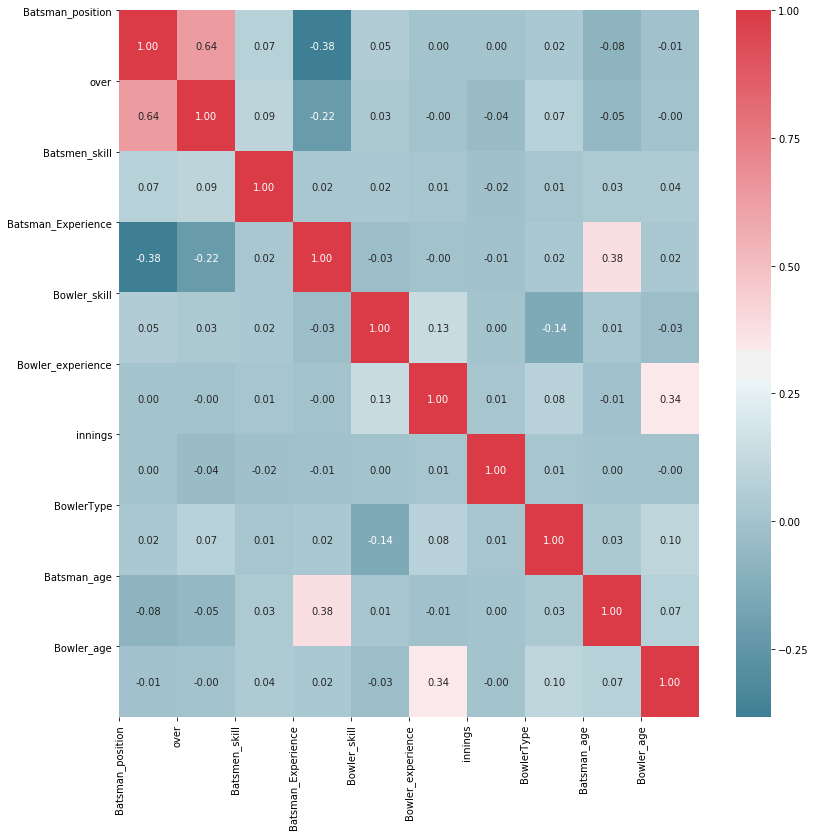

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = data[num_feats].corr()
fig, ax = plt.subplots(figsize=(13, 13))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22137 entries, 729302,1,06 to 419156,2,13
Data columns (total 10 columns):
Batsman_position      22137 non-null float64
over                  22137 non-null int64
Batsmen_skill         22137 non-null float64
Batsman_Experience    22137 non-null float64
Bowler_skill          22137 non-null float64
Bowler_experience     22137 non-null float64
innings               22137 non-null int64
BowlerType            22137 non-null int64
Batsman_age           22137 non-null int64
Bowler_age            22137 non-null int64
dtypes: float64(5), int64(5)
memory usage: 1.9+ MB


In [101]:
import xgboost as xgb
clf1 = xgb.XGBClassifier(learning_rate=0.01, n_estimators= 800,n_jobs=-2,n_fold=10)
clf1.fit(X, y)
y_pred_xgb = clf1.predict(x_val)
accuracy_score(y_val,y_pred_xgb)

/home/bukka/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7800977343402932

In [102]:
from sklearn.ensemble import RandomForestClassifier
clf_rdf= RandomForestClassifier(n_estimators=100,n_jobs=-1)
clf_rdf.fit(X,y)
y_pred_rdf = clf_rdf.predict(x_val)
accuracy_score(y_val,y_pred_rdf)

0.7743225233229676

In [103]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))

# X=pd.DataFrame(scaler.fit_transform(X),columns=num_feats)
# x_val=pd.DataFrame(scaler.fit_transform(x_val),columns=num_feats)

# # exp.head(20)

In [104]:
# from sklearn import svm
# clf_svm= svm.SVC() 
# clf_svm.fit(X, y)
# y_pred_svm = clf_svm.predict(x_val)
# accuracy_score(y_val,y_pred_svm)

In [105]:
# from sklearn.linear_model import LogisticRegression
# clf_lr = LogisticRegression()
# clf_lr.fit(X, y)
# y_pred_lr= clf_lr.predict(x_val)
# accuracy_score(y_val,y_pred_lr)

In [106]:
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier()
# neigh.fit(X, y) 
# y_pred_knn = clf1.predict(x_val)
# accuracy_score(y_val,y_pred_knn)

<BarContainer object of 10 artists>

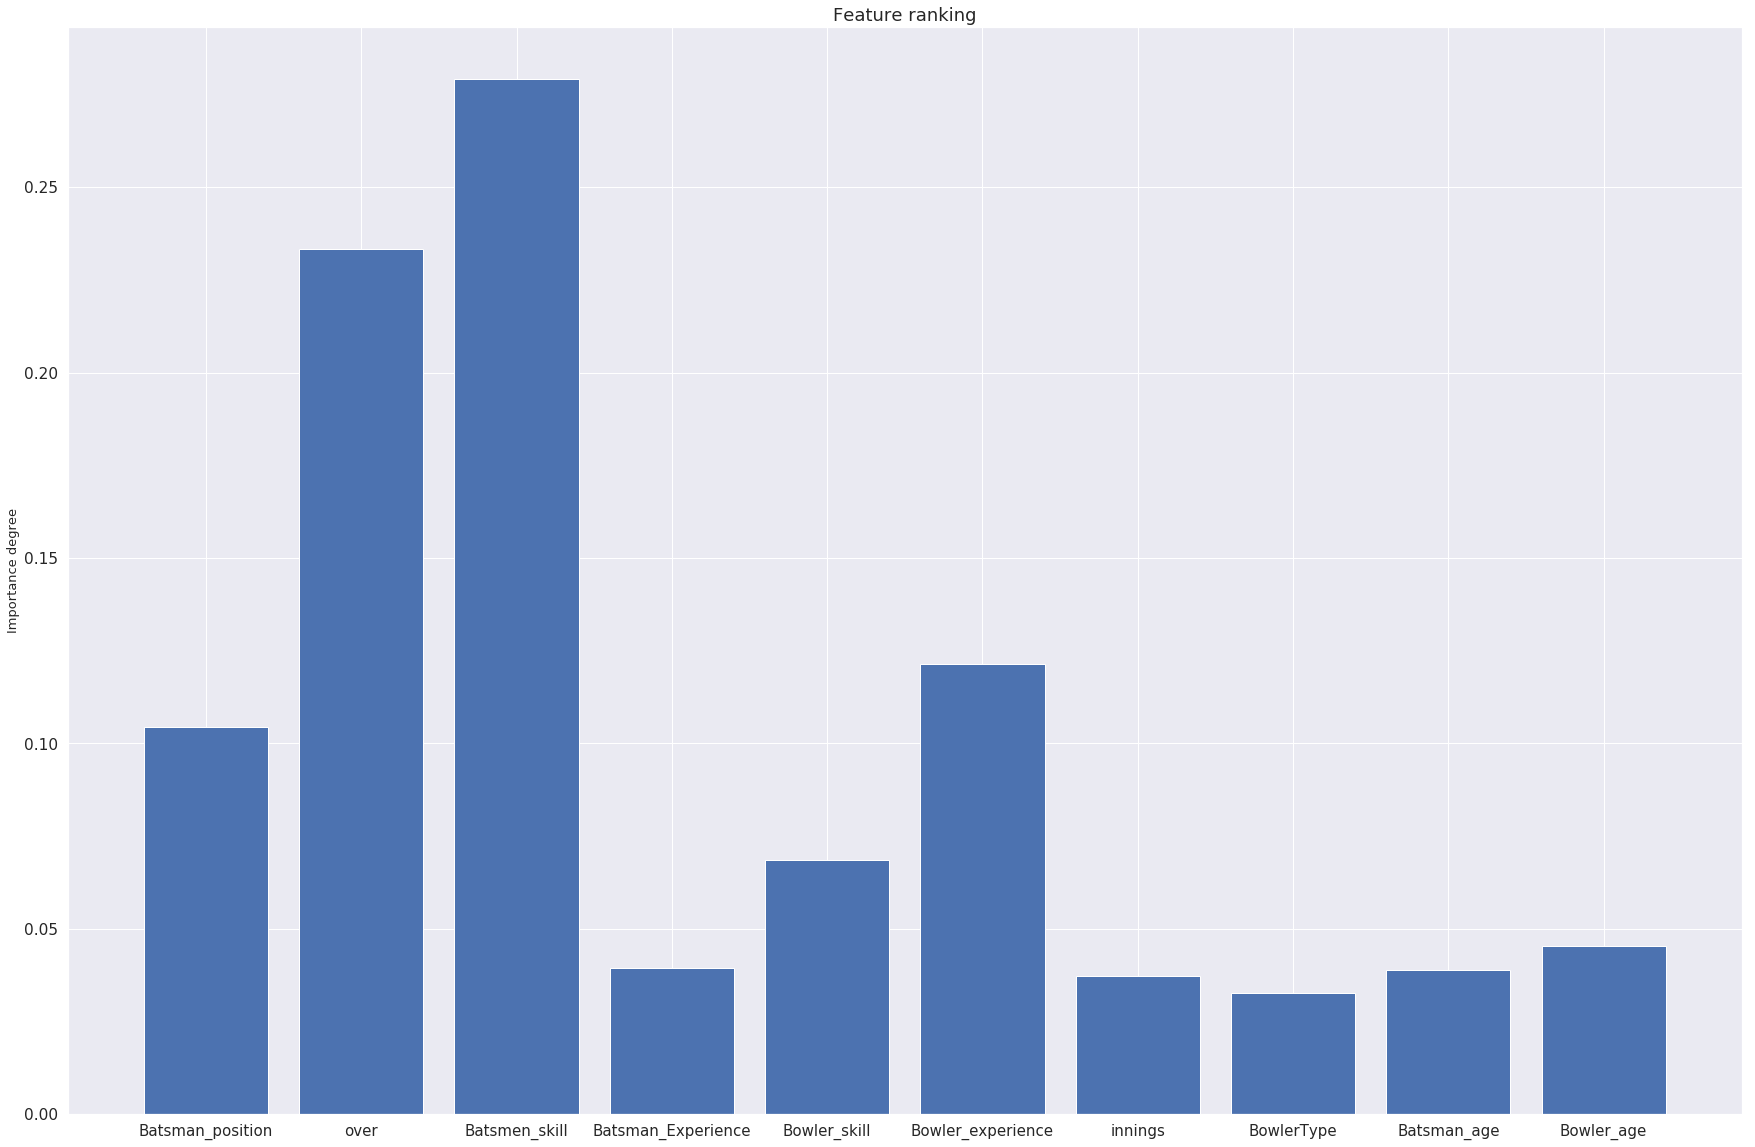

In [107]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(30,20))
plt.title('Feature ranking', fontsize = 18)
plt.ylabel('Importance degree', fontsize = 13)
# plt.xlabel("Features", fontsize = 14)

feature_names = num_feats
plt.xticks(range(len(num_feats)), feature_names, fontsize = 15)
plt.bar(range(len(clf1.feature_importances_)), clf1.feature_importances_)

In [108]:
data.to_csv("ProcessedData.csv")

In [109]:
import seaborn as sn
def ConfusionMatrix(y_test,y_predicted):
    a=0
    b=0
    c=0 
    d=0
    for i in range(0,len(y_test)):
        if(not(y_test[i]) and not(y_predicted[i])):
            a=a+1
        if(not(y_test[i]) and y_predicted[i]):
            b=b+1
        if(y_test[i] and not(y_predicted[i])):
            c=c+1
        if((y_test[i]) and (y_predicted[i])):
            d=d+1
    cnf_mat=[[a,b],[c,d]]
    df_cm = pd.DataFrame(cnf_mat,range(2),range(2))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
    plt.show()
    return cnf_mat

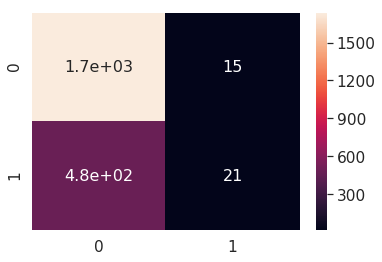

[[1735, 15], [480, 21]]

In [110]:
ConfusionMatrix(y_val.values,y_pred_xgb)
# print(y_val.values)
# # print("----------------------------")
# # print(y_pred)


In [111]:
# Tune learning_rate
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy as np

/home/bukka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/bukka/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bukka/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bukka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bukka/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bukka/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    sel

In [112]:
# model = xgb.XGBClassifier()
# n_estimators = [100, 200, 400,600,800]
# learning_rate = [0.01, 0.05,0.1,0.2,0.3,0.4]
# param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
# # plot results


In [113]:
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# pyplot.legend()
# pyplot.xlabel('n_estimators')
# pyplot.ylabel('accuracy')
# # pyplot.savefig('../metrics/n_estimators_vs_learning_rate1.png')

In [115]:
import pickle
# Dump the trained decision tree classifier with Pickle
decision_tree_pkl_filename = 'xgboost_matchindependent.pkl'
# Open the file to save as pkl file
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(clf1, decision_tree_model_pkl)
# Close the pickle instances
decision_tree_model_pkl.close()